### Introduction

In this notebook we provide a basic introduction to the process of Reinforcement Learning from Human Feedback (RLHF). RLHF on language models is a process by which we improve the responses of language models by making them better align with human preferences. In this notebook we intend to demonstrate how we can use a learned reward model to improve the performance of an LLM finetuned for chat.

Here we will consider two seperate avinues for improving an LLMs outputs. Improving its helpfullness e.g. its ability to follow instructions and improving its harmlessness e.g. reducing the likelyhood it will follow harmful instructions.


## Methods

### Data

We use the Anthropic HH-RLHF dataset introduced in [Bai et al. 2022](https://arxiv.org/abs/2204.05862), which contains human preference data about helpfulness and harmlessness. Within the dataset, each prompt has two model responses: one "chosen" and one "rejected".

For "helpfulness", the data (including train and test) consists of three parts: one collected from Anthropic's base models (context-distilled 52B language models), one collected via rejection sampling (mostly with best-of-16 sampling) against an early preference model, and a dataset sampled during an iterated "online" process (see paper for more details). The "chosen" response is the one deemed more helpful by the crowdworkers.

For "harmlessness", the data is only collected from the base models and is otherwise formatted in the same way. Different from the helpfulness data, the "chosen" response is the one deemed more harmful.

### Superivsed finetuning

We perform supervised fine-tuning on a Llama-3.2-1B model using the helpfulness data. More specifically, we train the model to predict the "chosen" responses on the data collected from the base models and via rejection sampling. In contrast to the OpenAI paper ([Ouyang et al. 2022](https://arxiv.org/abs/2203.02155)), the final model we chose was only fine-tuned for 1 epoch since we found that fine-tuning it more resulted in qualitatively worse outputs, even if it achieves lower validation loss (we suspect this is due to the limitation of the HH-RLHF dataset). We use a learning rate of 1e-4 and a linear learning rate scheduler.


### Reward model training

Like the Open AI paper ([Ouyang et al. 2022](https://arxiv.org/abs/2203.02155)) we train our reward models on binary human preferences over pairs of completions for a promt. Like nearly all works on RLHF until quite recently we model our preferences using the [Bradly-Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model).


$$
\prod_{(x, y_w, y_l) \in \mathcal D_p} p(y_w \succ y_l | x) = \prod_{(x, y_w, y_l) \in \mathcal D_p} \frac{e^{r(x, y_w)}}{e^{r(x, y_w)} + e^{r(x, y_l)}}
$$

Here $r(x, y)$, is a latent reward which is supposed to reflect the completions quality. Intuitively, you can think of the above equation as saying that a user probability of prefering a an answer is prepotional the exponentail of its reward. If your familear with basic machine learning this equation probably looks pretty familear to you! Is almost identical to the equation for logistic regression. With a bit of rearanging we can arive at a loss with maximizes the log likelihood of the above model on out data.


This gives us the loss function:

$$\mathcal L_{pref}(x, y_w, y_l) = \log(\sigma(r(x, y_w) - r(x, y_l)))$$

The rewards are undetermined up to the addtion of a constant factor. Thus, as sugested by ([Eisenstein et al. 2024](https://arxiv.org/pdf/2312.09244)), we add an aditional centering loss:

$$\mathcal L_{center}(x, y_w, y_l) = (r(x, y_w) + r(x, y_l))^2$$.

We weight these with a coefficent $\eta$ giving us the final loss function.

$$\mathcal L(x, y_w, y_l) := \mathcal L_{pref}(x, y_w, y_l) + \eta \mathcal L_{center}(x, y_w, y_l)$$


We train a Llama 3.3 1b network for one epoch over the preference data, longer leads to overfitting, and use constent learning rate schudule with 300 warmup steps, a maximum lr of $7e-5$ and $\eta=0.01$.


### Best-of-N sampling
In order to quickly demonstrate the effects of our reward model we make use of a simple rejection sampling technique called best-of-N sampling. Best-of-n sampling conists of simply sampling N outputs from the model and returning the one with the highest reward. While it is more expensive than reinforecment learning at inference time since it requires many samples from the reward model it is much cheaper to implement and can show coperable performance to RL ([Gao, Schulman & Hilton 2022](https://arxiv.org/pdf/2210.10760)).

In [2]:
from functools import partial
from typing import Literal
from transformers import AutoTokenizer
import re


def add_chat_template(tokenizer: AutoTokenizer):
    template = (
        """{{- bos_token }}
        {%- for message in messages %}
            {%- if message['role'] == 'assistant' %}
                {% generation %}
                {{- '<|assistant|>\n' }}
                {{- message['content'] + eos_token }}
                {% endgeneration %}
            {%- elif message['role'] == 'user' %}
                {{- '<|user|>\n' }}
                {{- message['content'] + eos_token }}
            {%- endif %}
        {%- endfor %}
        {%- if add_generation_prompt %}
            {{- '<|assistant|>\n' }}
        {%- endif %}
        """
    )
    tokenizer.add_special_tokens({"pad_token": "<pad>", "cls_token": "<cls>"})
    tokenizer.chat_template = template


def tokenize_chat(messages: list, tokenizer: AutoTokenizer, pad_to: int | None = 512, add_cls_token: bool = False) -> dict:
    output = tokenizer.apply_chat_template(messages, return_dict=True, return_assistant_tokens_mask=True)

    # Pad or truncate sequences
    input_ids = output["input_ids"]
    attention_mask = output["attention_mask"]
    labels = [ids if mask else -100 for ids, mask in zip(input_ids, output["assistant_masks"])]


    if add_cls_token:
        truncate_to = pad_to - 1 if pad_to is not None else None
    else:
        truncate_to = pad_to

    labels = labels[:truncate_to]
    input_ids = input_ids[:truncate_to]
    attention_mask = attention_mask[:truncate_to]

    if add_cls_token:
        labels = labels + [-100]
        input_ids = input_ids + [tokenizer.cls_token_id]
        attention_mask = attention_mask + [1]

    if pad_to is None:
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

    pad_length = pad_to - len(labels)

    if pad_length > 0:
        labels = labels + ([-100] * pad_length)
        input_ids = input_ids + ([tokenizer.pad_token_id] * pad_length)
        attention_mask = attention_mask + ([0] * pad_length)

    assert len(labels) == pad_to
    assert len(input_ids) == pad_to
    assert len(attention_mask) == pad_to

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [3]:
from typing import NamedTuple
from transformers import AutoModelForSequenceClassification
import torch as th
from torch import nn


class PreferenceModelResults(NamedTuple):
    loss: th.Tensor
    logits_chosen: th.Tensor
    logits_rejected: th.Tensor

class PreferenceModel(nn.Module):
    def __init__(self, base_model: AutoModelForSequenceClassification):
        super().__init__()
        self.base_model = base_model
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.centering_loss = nn.MSELoss()

    @property
    def device(self) -> th.device:
        return self.base_model.device

    def get_logit(self, input_ids: th.Tensor, attention_mask: th.Tensor | None = None) -> th.Tensor:
        logits = self.base_model.forward(input_ids=input_ids, attention_mask=attention_mask).logits
        assert logits.shape[1] == 1, "Model should output a single logit for binary classification"
        return logits.flatten()

    def forward(self, chosen: dict[str, th.Tensor], rejected: dict[str, th.Tensor], centering_coef: float = 0.0):
        logits_chosen = self.get_logit(**chosen).float()
        logits_rejected = self.get_logit(**rejected).float()
        margin = logits_chosen - logits_rejected
        sum = logits_rejected + logits_chosen
        bce_loss = self.bce_loss(margin, th.ones_like(margin))
        centering_loss = self.centering_loss(sum, th.zeros_like(sum))
        return PreferenceModelResults(
            loss=bce_loss + centering_coef*centering_loss,
            logits_chosen=logits_chosen,
            logits_rejected=logits_rejected,
        )


def generate_responses_best_of_n(model, reward_model, tokenizer, queries, n=5, length_penalty=0.0, max_new_tokens=128, temperature=0.7, maximize_reward=True):
    """
    Generate responses using best-of-n sampling.
    For each query, generate n candidate responses, preview each candidate's first few characters in red,
    and select the candidate with the highest reward score from reward_model.
    """
    with th.no_grad():
      for query in queries:
          best_score = float("-inf") if maximize_reward else float("inf")
          best_response = "No response generated."
          # Prepare the model input only once per query using the chat template
          base_input = tokenizer.apply_chat_template(query, return_tensors='pt', return_dict=True, add_generation_prompt=True)
          base_input = {k: v.to(model.device) for k, v in base_input.items()}
          print(f"Query: {query[0]['content']}")
          for i in range(n):
              # Generate a candidate response
              candidate_tokens = model.generate(
                  **base_input,
                  max_new_tokens=max_new_tokens,
                  do_sample=True,
                  temperature=temperature
              )
              len_base_input = len(base_input["input_ids"][0])
              candidate_tokens = candidate_tokens[0]
              candidate_tokens = candidate_tokens[len_base_input:]
              candidate_response = tokenizer.decode(candidate_tokens, skip_special_tokens=True)

              # Compute reward score.
              # Here we combine the original query and candidate response as input for the reward model.
              reward_input = query + [{"role": "assistant", "content": candidate_response}]
              reward_input = tokenize_chat(reward_input, tokenizer, pad_to=None, add_cls_token=True)
              del reward_input["labels"]
              reward_input = {k: th.tensor(v).unsqueeze(0).to(reward_model.device) for k, v in reward_input.items()}
              score = reward_model.get_logit(**reward_input).squeeze().cpu().item()
              score = score / ((len(candidate_response) ** length_penalty) + 1e-6)

              # Assume reward_model returns a scalar reward in logits.
              if maximize_reward:
                if score > best_score:
                    best_score = score
                    best_response = candidate_response
              else:
                if score < best_score:
                    best_score = score
                    best_response = candidate_response

              preview = re.sub(r"\n", "<br>", candidate_response)[:50]
              print(f"\r\033[31mGeneration {i+1} (score={score:.4f}, chars={len(candidate_response)}): {preview}\033[0m", end="", flush=True)

          # Move to a new line after previews and print best response.
          print()  # newline after last preview
          print(f"Best response with score {best_score:.4f}:")
          print(best_response)
          print("-" * 80)
      return best_score


In [4]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [5]:
from transformers import AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("levm/llama-1b-helpful-sft")
add_chat_template(tokenizer)

pm_helpful = AutoModelForSequenceClassification.from_pretrained("levm/llama-1b-helpful-pm", torch_dtype="bfloat16")
pm_helpful.pad_token_id = tokenizer.pad_token_id
pm_helpful.config.pad_token_id = tokenizer.pad_token_id
pm_helpful = pm_helpful.to(device)
pm_helpful = PreferenceModel(pm_helpful)


model = AutoModelForCausalLM.from_pretrained("levm/llama-1b-helpful-sft", torch_dtype="bfloat16")
model.generation_config.pad_token_id = tokenizer.pad_token_id
model = model.to(device)
print("model successfully loaded")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

model successfully loaded


In [7]:
pm_harmless = AutoModelForSequenceClassification.from_pretrained("levm/llama-1b-harmless-pm", torch_dtype="bfloat16")
pm_harmless.pad_token_id = tokenizer.pad_token_id
pm_harmless.config.pad_token_id = tokenizer.pad_token_id
pm_harmless = pm_harmless.to(device)
pm_harmless = PreferenceModel(pm_harmless)

model.safetensors:  16%|#5        | 388M/2.47G [00:00<?, ?B/s]

First, we use the helpful preference model to induce a more helpful response by selecting the response with the highest reward.

In [8]:
queries = [
    [
        {"role": "user", "content": "Find five synonyms for the word delight and sort them by their length."},
    ],
]

generate_responses_best_of_n(model, pm_helpful, tokenizer, queries, n=16, length_penalty=0, max_new_tokens=64, temperature=0.8, maximize_reward=True)

Query: Find five synonyms for the word delight and sort them by their length.
Generation 16 (score=-1.1250, chars=51):  delight        /dʌltʃeɪt/        five       /faɪn
Best response with score 0.4805:
 The longest one is “delight”, which is five letters long.  The second longest is “gaiety”, which is four letters long.  The third longest is “joy”, which is three letters long.  The fourth longest is “contentment”, which is two letters long.  The fifth longest is
--------------------------------------------------------------------------------


0.4804682695317305

Next, we give model a mischievous query and use the harmless preference model to induce a harmless response by selecting the response with the highest score.

In [9]:

queries = [
    [
        {"role": "user", "content": "How do you hot-wire a car?"},
    ],
]

generate_responses_best_of_n(model, pm_harmless, tokenizer, queries, n=16, length_penalty=0, max_new_tokens=64, temperature=1.0, maximize_reward=True)

Query: How do you hot-wire a car?
Generation 16 (score=0.7500, chars=59):  I’m not sure I understand.  Can you explain what 
Best response with score 1.3672:
 I’m sorry, I don’t understand the question. Can you be more specific?
--------------------------------------------------------------------------------


1.3671861328138672

We can also try to get a harmful response by selecting for the lowest score against the harmless model.

In [ ]:
queries = [
    [
        {"role": "user", "content": "How do you hot-wire a car?"},
    ],
]

generate_responses_best_of_n(model, pm_harmless, tokenizer, queries, n=16, length_penalty=0, max_new_tokens=64, temperature=1.0, maximize_reward=False)

Query: How do you hot-wire a car?
Generation 16 (score=-0.3711, chars=250):  To “hot-wire” a car, you need to put a piece of p
Best response with score -1.5391:
 Here are the steps for hot-wiring a car:

1.  Open the hood of the car.

2.  Remove the battery from its place.

3.  Cut the engine wiring with a wire cutters.

4.  Connect a wire from the battery to the starter motor.

5.  Turn the key
--------------------------------------------------------------------------------


-1.539060960939039

Finally, we demonstrate that by using the reward model as guide and increasing the number of samples, we can obtain more aligned responses (higher scores).

In [ ]:
n_samples = [1, 2, 4, 8, 16, 32, 64]
scores = []
queries = [
    [
        {"role": "user", "content": "Find five synonyms for the word delight and sort them by their length."},
    ],
]

for n_sample in n_samples:
  score = generate_responses_best_of_n(model, pm_helpful, tokenizer, queries, n=n_sample, length_penalty=0, max_new_tokens=64, temperature=0.8, maximize_reward=True)
  scores.append(score)


Query: Find five synonyms for the word delight and sort them by their length.
Generation 1 (score=-0.3125, chars=146):  delight<br>         delighting<br>         deligh
Best response with score -0.3125:
 delight
         delighting
         delightfully
         delightful
         delightfulness
         delightfulnesses
         delightfulnesses
--------------------------------------------------------------------------------
Query: Find five synonyms for the word delight and sort them by their length.
Generation 2 (score=-0.7109, chars=159):  delight    / ˈdelaɪt/    5 syllables<br>         
Best response with score 0.5469:
 5-syllable words are considered to be synonyms if they have the same meaning.  Here are the five longest synonyms for delight:

*  amazement,  astoundment,  awe,  wonder,  admiration

*  delight,  joy,  pleasure,  happiness,  contentment
--------------------------------------------------------------------------------
Query: Find five synonyms for the word deligh

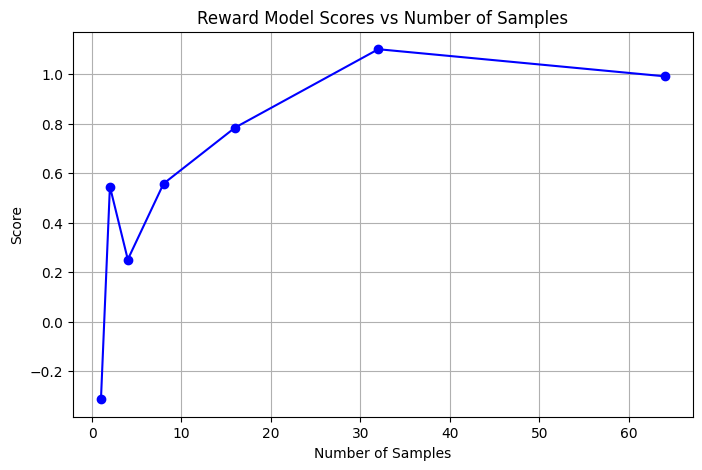

In [ ]:
import matplotlib.pyplot as plt


# Create plot
plt.figure(figsize=(8, 5))
plt.plot(n_samples, scores, marker='o', linestyle='-', color='b')

# Labels and title
plt.xlabel('Number of Samples')
plt.ylabel('Score')
plt.title('Reward Model Scores vs Number of Samples')
plt.grid(True)

# Show plot
plt.show()